In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def visualize_accumulations(v,J,a,num_steps,beta,accumulation_hist,dt=1e-3,scale=1.0,max_time=10.):
    """Produces a simple plot of multiple accumulations.
    
    Parameters:
    -----------
    other params: taken from FFI sim, used to beautify output and properly parse accumulation_hist
    accumulation_hist : accumulation history of FFI simulation

    Returns:
    --------
    f : plt.Figure
        The figure instance (for saving etc...)
    """
    colors = ['#AA0000', '#00AA00', '#0000AA']
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    for j in range(J):
        ax.plot(np.arange(0,num_steps,dt)[:len(accumulation_hist)],np.array(accumulation_hist)[:,j],color=colors[j],label=f'Alternative {j}')
    ax.axhline(y=a, color='gray',linestyle='--',label='Decision Threshold')
    ##Full Disclaimer, I used Chat-GPT for help with formatting the graph and labels, we will forever hate mathplotlib
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Accumulator Value')
    ax.set_title('Visualization of Accumulator History')
    ax.legend()
    ax.grid(True)
    plt.show()

In [58]:
def simulate_FFI(v,x0,a,tau,beta,accumulation_hist,dt=1e-3,scale=1.0,max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : np.ndarray
        The drift rates (rates of information uptake)
    x0    : np.ndarray
        The starting points
    a     : float
        The boundary separation (decision threshold).
    beta  : float in [0, inf+)
        Inhibition parameter
    tau   : float [0 , inf+)
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: 10.)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """
    num_steps=tau
    const=scale*np.sqrt(dt)
    x=x0.copy()
    assert x.shape[0] == v.shape[0]
    J=x0.shape[0]
    
    #In theory store accumulations
    #accumulation_history = []
    #we begin looping through the simulation here
    while num_steps<=max_time:
        #random noise
        z=np.random.randn(J)
        #accumulate
        for j in range(J):
            #FFI equation
            dx_j=(v[j]-beta*sum(x))*dt+const*z[j]
            x[j] = max(x[j] + dx_j, 0)
            accumulation_hist.append(x.copy())
        #Steppy
        num_steps +=dt
        #boundary check
        if any(x >= a):
            break
    ##continue, ruin tau forever, btu with little consequence since simulation is over and we need updated output to print. Or maybe this doesnt work because tau is immutable? Pain.
    ##Could in theory, print inside here, but that fucks up how neat and purdy this all is, and i'd rather not.
    ## i might have to regardless in order for any of this to print right, ************************************ I hate it here
    visualize_accumulations(v,J,a,num_steps,beta,accumulation_hist,dt=1e-3,scale=1.0,max_time=10.)
    ##if this doesnt work I give up, extra 2 points is not worth it
    
    return (round(num_steps, 3), x.argmax())
def simulate_FFI_n(num_sims, **kwargs):
    data = np.zeros((num_sims, 2))
    #a_data=np.zeros((num_sims, 2))
    for n in range(num_sims):
        (data[n, :]) = simulate_FFI(**kwargs)
    return (data)

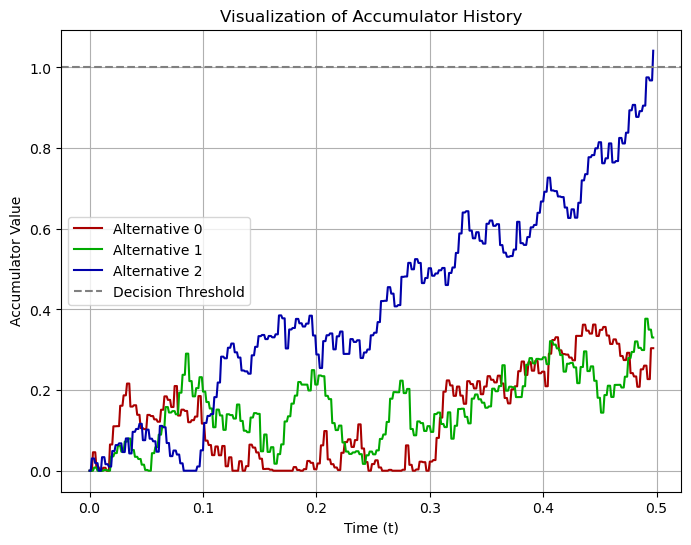

[[0.666 2.   ]]


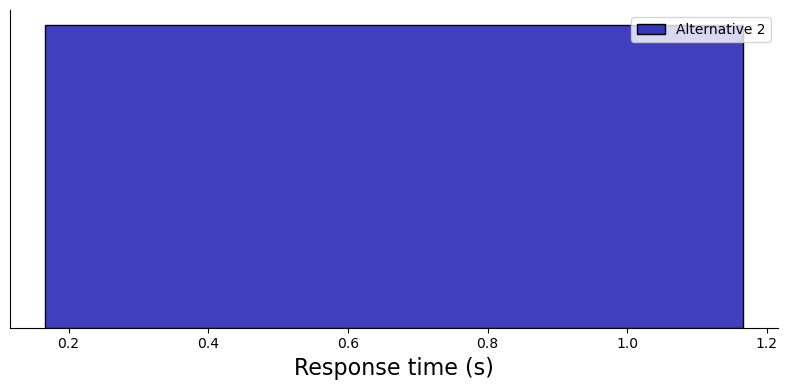

In [59]:
# Simulation parameters
accumulation_hist=[]
parameters = {
    'v': np.array([1., 1., 3.]),
    'x0': np.zeros(3),
    'a': 1.,
    'tau': 0.5,
    'beta': 0.6,
    'accumulation_hist': accumulation_hist
}

# Simulator (for n_obs)
sim_data = simulate_FFI_n(1, **parameters)
print(sim_data)

# Visualize empirical RT distribution
f, ax = plt.subplots(1, 1, figsize=(8, 4))
colors = ['#AA0000', '#00AA00', '#0000AA','purple']
for j in range(parameters['v'].shape[0]):
    sns.histplot(sim_data[:, 0][sim_data[:, 1] == j], color=colors[j], label=f'Alternative {j}')
ax.legend()
sns.despine(ax=ax)
ax.set_xlabel('Response time (s)', fontsize=16)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_yticks([])
f.tight_layout()